In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# modify the path below accordingly
PATH = "/content/drive/MyDrive/compvision/gesture_face_features"

In [6]:
# !pip install mediapipe

In [5]:
# importing .py files from /code
import sys
import os
sys.path.append(os.path.join(PATH, "code"))

%load_ext autoreload
%autoreload 2

from utils import *
from config import Config, available_models
from heatmap import Heatmap
from hand_extraction import extract_hand_mp

from copy import deepcopy

In [ ]:
# configs = {}
# img_type="both"
# letter = None
# is_random = True
# first_model = available_models[next(iter(available_models))]

# for model_name in available_models.values():
#   print("Configuring model", model_name, "for", img_type, "images, for letter", letter)
#   load_data = model_name == first_model # Loading data only for the first model
#   conf = Config(PATH, img_type=img_type, letter=letter, model_name=model_name, load_data=load_data, is_random=is_random)
#   if not load_data:
#     conf.imgs = deepcopy(configs[first_model].imgs)
#     conf.heatmap_config[7] = conf.imgs
#   configs[model_name] = conf
#   print()

# orig_imgs = deepcopy(configs[first_model].imgs)

In [15]:
vgg = Config(PATH, img_type='sign', model_name='VGG19', load_data=True, debug=True, is_random=True)

Loading data...
Data loaded successfully.
Setting up model VGG19...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

1/1 [==============================] - 1s 680ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 834
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 1s/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 655
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 680ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Sh

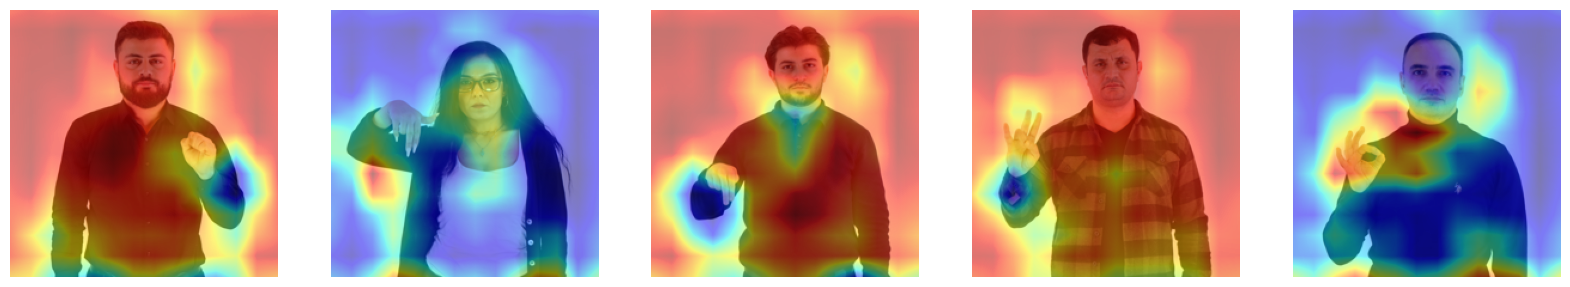

1/1 [==============================] - 1s 725ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 523
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 657ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 834
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 679ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image

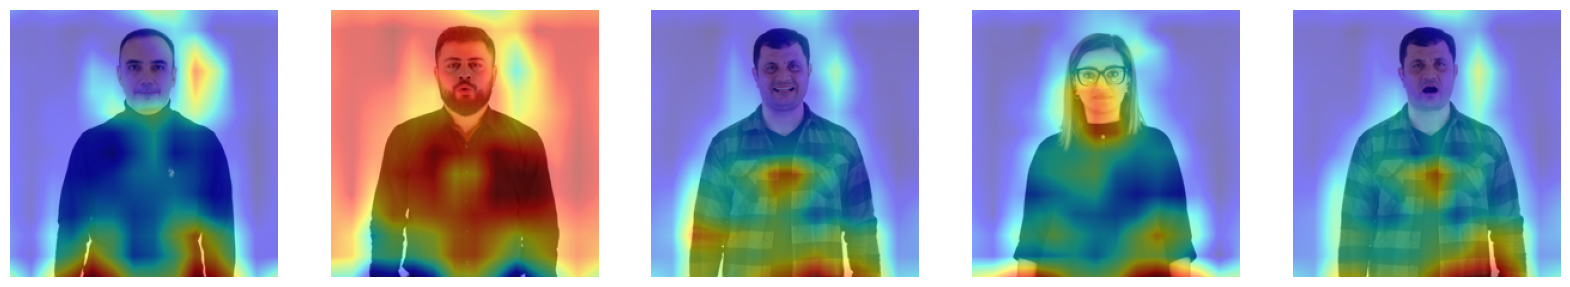

In [27]:
hm = Heatmap(*vgg.heatmap_config)
hm.generate_heatmaps_row(img_count=5, imgs_per_row=5)

In [ ]:
conf = configs['VGG19']
hm = Heatmap(*conf.heatmap_config)
# hm.generate_heatmaps(save=True)
# hm.load_heatmaps()
hm.generate_heatmaps_row(img_count=5, imgs_per_row=5)

5
5


dict_keys(['VGG19', 'ResNet50', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB6'])

1/1 [==============================] - 0s 188ms/step


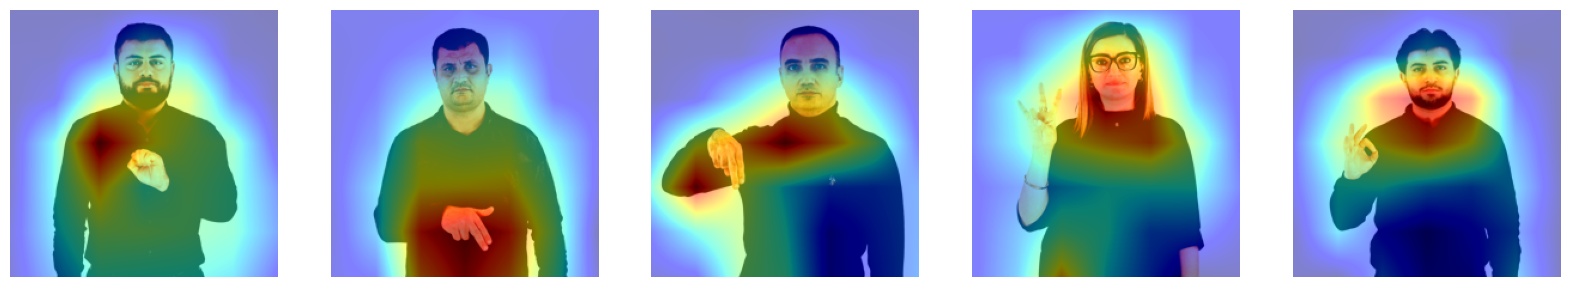

1/1 [==============================] - 0s 180ms/step


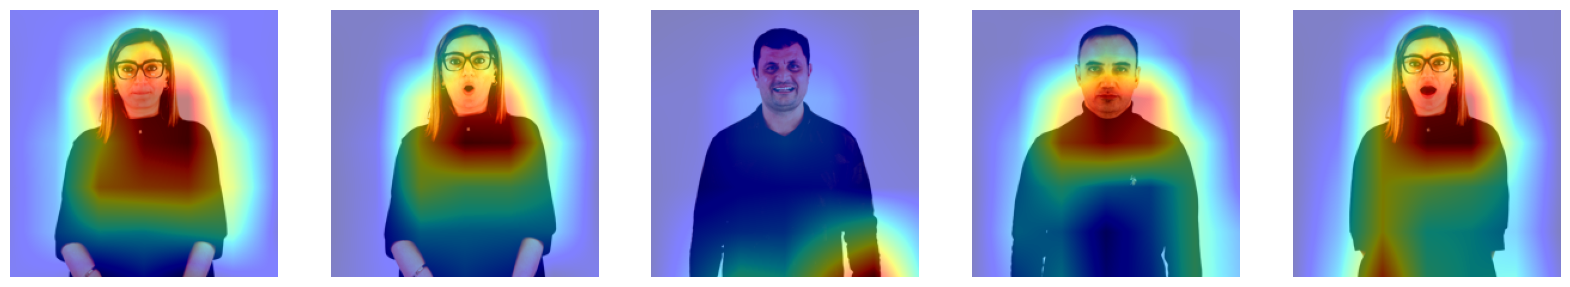

In [ ]:
factor = 2

contrasted_sign = adjust_contrasts(conf.imgs["sign"], factor)
contrasted_face = adjust_contrasts(conf.imgs["face"], factor)

conf.imgs["sign"] = contrasted_sign
conf.imgs["face"] = contrasted_face

# conf.imgs["sign"] = orig_imgs["sign"]
# conf.imgs["face"] = orig_imgs["face"]

hm.generate_heatmaps_row(img_count=5, imgs_per_row=5)

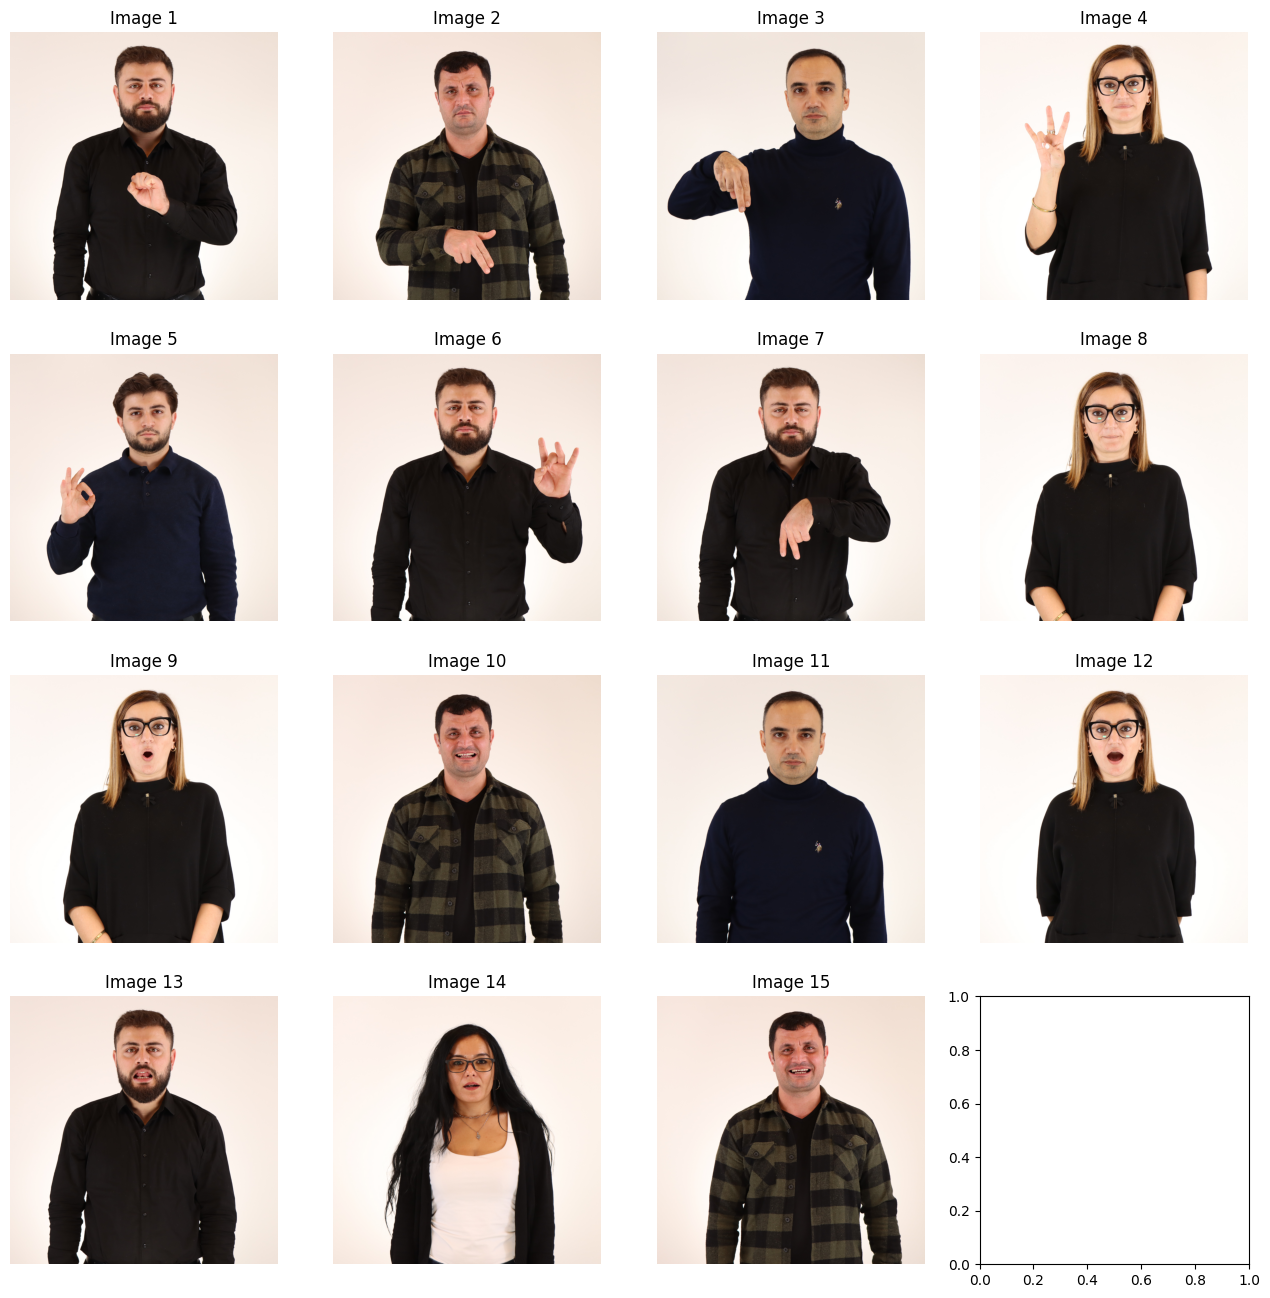

In [ ]:
plot_imgs(orig_imgs["both"], 4)

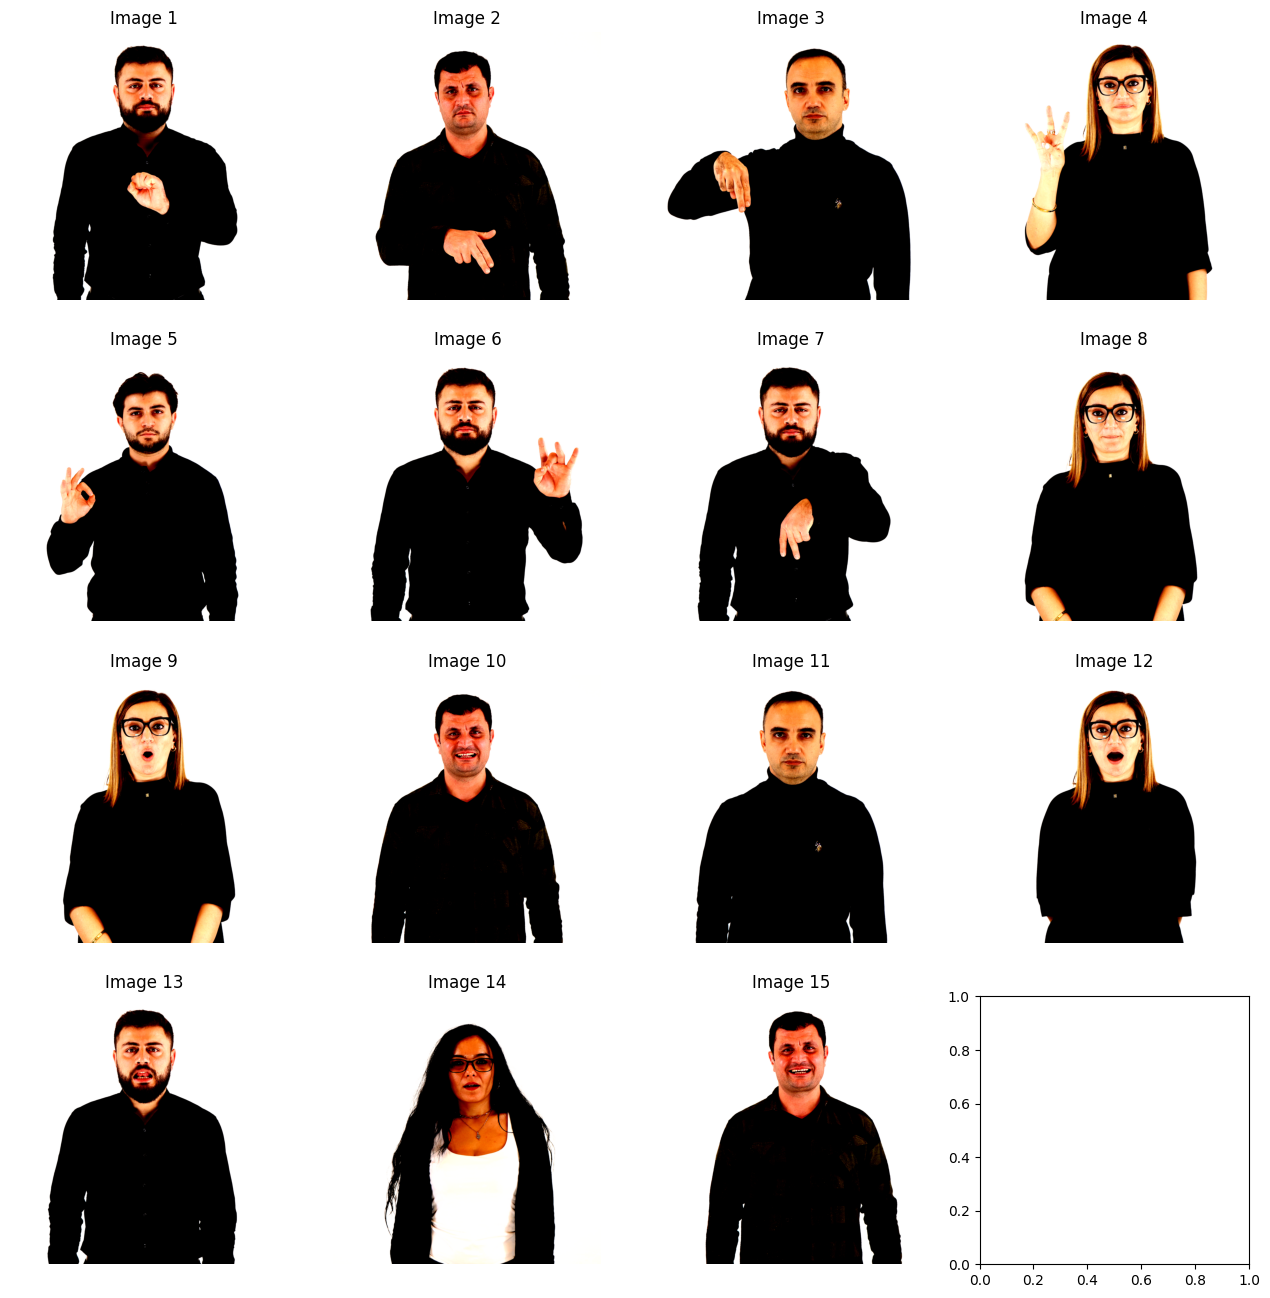

In [ ]:
plot_imgs(contrasted, 4)

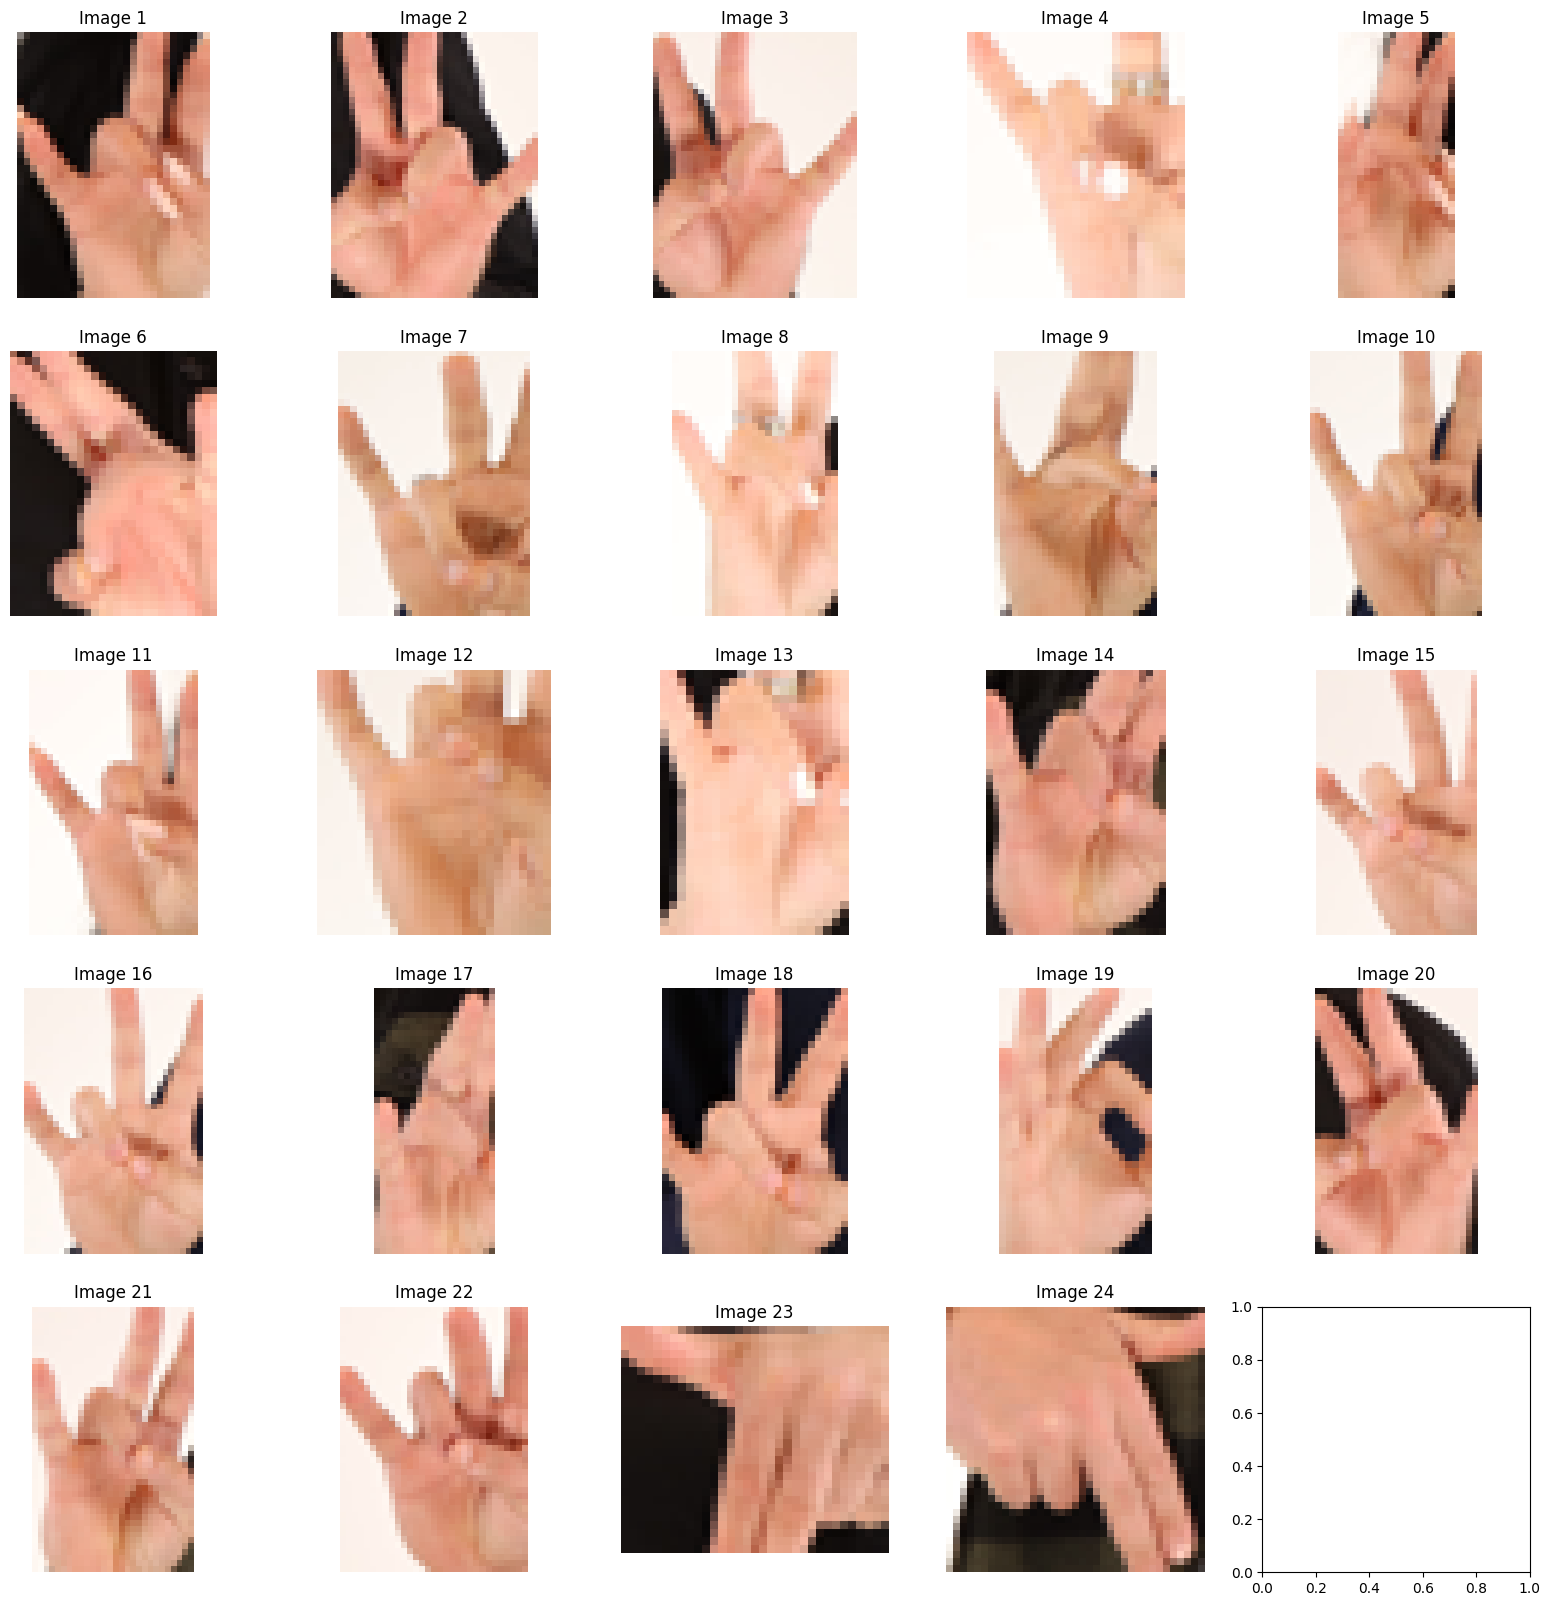

In [ ]:
hand_path = os.path.join(PATH, "cropped_hands")
# input_dim = (224, 224)
# extract_hand_mp(conf.imgs["sign"], input_dim, output_path=hand_path)
plot_imgs(hand_path, imgs_per_row=5)